
# A Notebook to prepare gridded climate time series data for DHSVM modeling of the Sauk Watershed  <br />
This workflow was originally developed to digitally observe the Sauk-Suiattle Watershed, and is expanded here to the Skagit watershed. Low elevation observations are used to correct modeled atmospheric data based on the differences in the long term mean monthly temperature and precipitation. This is expected to improve hydrologic modeling at low elevations, and we are prioritizing predictions of low flows in low elevation tributaries. Limited analysis conducted to date shows that this approach may not be an accurate representation of high elevation processes.  This is an area of active research.
<br /><br />
<img src= "http://www.sauk-suiattle.com/images/Elliott.jpg"
style="float:left;width:200px;padding:20px">   

*Use this Jupyter Notebook to:* <br /> 
Download and generate lists of gridded climate points<br />
Download Livneh daily 1/16 degree gridded climate data, <br /> 
Download WRF daily 1/16 degree gridded climate data, <br /> 
Visualize daily, monthly, and annual temperature and precipitation data. <br /> 
Calculate Long-term Mean Monthly Bias Corrections for WRF using Livneh Low Elevation data<br /> 
Bias correct each Livneh grid cell using bias corrected WRF (use to correct Livneh 2013 and MACA data). <br />
Visualize daily, monthly, and annual temperature and precipitation data with corrected results. <br /> 
Update VIC model soil input (optional). <br /> 
Save results back to HydroShare. <br /> 
 <br /> <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:20px">  
#### A Watershed Dynamics Model by the Watershed Dynamics Research Group in the Civil and Environmental Engineering Department at the University of Washington 

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [8]:
#Python libraries available on CUAHSI JupyterHub 
import os
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta

%matplotlib inline
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

#HydroShare Utilities
from utilities import hydroshare

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [9]:
hs=hydroshare.hydroshare()

Adding the following system variables:
   HS_USR_NAME = ChristinaBandaragoda
   HS_RES_ID = 7c3416535ab24d4f93b0b94741bb9572
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => ChristinaBandaragoda
Successfully established a connection with HydroShare


In [10]:
import ogh
homedir = ogh.mapContentFolder(str(os.environ["HS_RES_ID"]))
print('Data will be loaded from and save to:'+homedir)

Data will be loaded from and save to:/home/jovyan/work/notebooks/data/7c3416535ab24d4f93b0b94741bb9572/7c3416535ab24d4f93b0b94741bb9572/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Download and generate lists of gridded climate points for a watershed
Retrieve a list of grid points and configuration file from a HydroShare resource
This example uses a ascii text that is stored in HydroShare at the following url: https://www.hydroshare.org/resource/d90289409f904017831d308642c1eb30/ . The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the table in this resource is the 'mappingfile' variable identifying the Lat/Long points to be used for downloading hydrometeorology data.  The file must include columns with station numbers (this can be aribitrary), latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.

### User provides their HydroShare resource ID from their own polgyon shapefile uploaded to HydroShare

In [11]:
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
shapefile = hs.content['wbdhuc12_17110006_WGS84.shp']

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


### Import the exising point shapefile of available 1/16 degree grid centroid locations shared on HydroShare as a public resource

In [12]:
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n


### Use TreatGeoSelf to generate a list of lat/long points in your area of interest
The TreatGeoSelf() function was designed to easily generate a list of lat/long points in your area of interest
Use the buffer distance in decimal degrees to select points within your polygon (distance=0) or within a 1/16 degree buffer outside of the polygon (distance = 0.0625).

In [13]:
mappingfile = ogh.treatgeoself(shapefile=shapefile, NAmer=NAmer, folder_path=os.getcwd(), outfilename='monkeysonatree.csv', buffer_distance=0.00)
print(mappingfile)

../../../../c532e0578e974201a0bc40a37ef2d284/c532e0578e974201a0bc40a37ef2d284/data/contents/wbdhuc12_17110006_WGS84.shp printed
Number of gridded points/files: 57
(57, 4)
    FID       LAT      LONG_    ELEV
52   52  48.03125 -121.15625  1585.0
53   53  48.03125 -121.21875  1382.0
54   54  48.03125 -121.28125  1035.0
55   55  48.03125 -121.34375  1373.0
56   56  48.03125 -121.40625  1188.0
/home/jovyan/work/notebooks/data/7c3416535ab24d4f93b0b94741bb9572/7c3416535ab24d4f93b0b94741bb9572/data/contents/monkeysonatree.csv


### Provide Location Name and watershed drainage area (m2)
#### Watershed information upstream of USGS 12200500 Skagit River near Mount Vernon, WA  
Location.--Latitude 48°26'42", Longitude 122°20'03", in SE 1/4 SE 1/4 Section 7, Township 34 North, Range 4 East, in Skagit County, Hydrologic Unit 17110007, on right bank 220 feet downstream of bridge on U.S. Highway 99, 1.5 miles north of Skagit Valley Junior College in Mount Vernon, and at river mile 15.7. Drainage area is 3,093 mi2, of which 400 mi2 is in Canada. Datum of gage is NGVD of 1929. 
https://waterdata.usgs.gov/nwis/uv?site_no=12200500

In [16]:
loc_name='Sauk Watershed'
streamflow_watershed_drainage_area=1849250000 #8010833000 # square meters

# Read in the Observatory metadata file 
This file contains the variables, data types and metadata related to Livneh et al., 2013; 2015 and Salathe et al., 2014 gridded hydrometeorology products. 

In [17]:
#Assuming this is pulled from Github, how can we import this from Utilities.
#Otherwise it needs to be in each HydroShare resource - which if fine too. 
with open('ogh_meta.json','r') as r:
    meta_file = json.load(r)
    r.close()

sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

 ## 3. Download climate data 

### Get Daily Meteorologic Data (1915-2011) from Livneh et al. 2013 

The functions used in this section apply to hydrometeorology data within the Continental United States with daily data 1915-2011. <br/>
View data extent at  Livneh, B. (2017). Gridded climatology locations (1/16th degree): Continental United States extent, HydroShare, http://www.hydroshare.org/resource/14f0a6619c6b45cc90d1f8cabc4129af

Please cite: <br/>
Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-Term Hydrologically Based Dataset of Land Surface Fluxes and States for the Conterminous United States: Update and Extensions, Journal of Climate, 26, 9384–9392.<br/>
<br/>
The getClimateData_DailyMET_livneh2013() function reads in the mapping file table, downloads, and unzips the data files for each of the longitude and latitude points. The folder containing the data is within the directory listed as homedir. 

In [18]:
help(ogh.getDailyMET_livneh2013)

Help on function getDailyMET_livneh2013 in module ogh:

getDailyMET_livneh2013(homedir, mappingfile, subdir='livneh2013/Daily_MET_1915_2011/raw', catalog_label='dailymet_livneh2013')
    Get the Livneh el al., 2013 Daily Meteorology files of interest using the reference mapping file
    
    homedir: (dir) the home directory to be used for establishing subdirectories
    mappingfile: (dir) the file path to the mappingfile, which contains the LAT, LONG_, and ELEV coordinates of interest
    subdir: (dir) the subdirectory to be established under homedir
    catalog_label: (str) the preferred name for the series of catalogged filepaths



In [19]:
Daily_MET_1915_2011 = ogh.getDailyMET_livneh2013(homedir, mappingfile)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.46875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.46875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.28125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.28125_-121.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.53125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.34375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.28125_-121.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.21875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.28125_-121.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.40625_-121.59375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.34375_-121.40625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.28125_


### Get Daily Weather Research and Forecasting (WRF 1950-2010 Pacific Northwest) from Salathe et al., 2014
<br/>
Please cite 2014 data using: <br/>
Salathé, EP, AF Hamlet, CF Mass, M Stumbaugh, S-Y Lee, R Steed: 2017. Estimates of 21st Century Flood Risk in the Pacific Northwest Based on Regional Scale Climate Model Simulations.  J. Hydrometeorology. DOI: 10.1175/JHM-D-13-0137.1

This data is also available on HydroShare and can be downloaded using the following line of code (copy into code block):
hs.getResourceFromHydroShare('0db969e4cfb54cb18b4e1a2014a26c82')


In [20]:
help(ogh.getDailyWRF_salathe2014)

Help on function getDailyWRF_salathe2014 in module ogh:

getDailyWRF_salathe2014(homedir, mappingfile, subdir='salathe2014/WWA_1950_2010/raw', catalog_label='dailywrf_salathe2014')
    Get the Salathe el al., 2014 raw Daily WRF files of interest using the reference mapping file
    
    homedir: (dir) the home directory to be used for establishing subdirectories
    mappingfile: (dir) the file path to the mappingfile, which contains the LAT, LONG_, and ELEV coordinates of interest
    subdir: (dir) the subdirectory to be established under homedir
    catalog_label: (str) the preferred name for the series of catalogged filepaths



In [21]:
Daily_WRFraw_1950_2010 = ogh.getDailyWRF_salathe2014(homedir, mappingfile)

downloaded: data_48.28125_-121.28125
downloaded: data_48.34375_-121.40625
downloaded: data_48.28125_-121.09375
downloaded: data_48.28125_-121.34375
downloaded: data_48.34375_-121.15625
downloaded: data_48.34375_-121.28125
downloaded: data_48.28125_-121.03125
downloaded: data_48.28125_-121.15625
downloaded: data_48.28125_-121.53125
downloaded: data_48.34375_-121.09375
downloaded: data_48.34375_-121.53125
downloaded: data_48.40625_-121.59375
downloaded: data_48.28125_-121.21875
downloaded: data_48.40625_-121.46875
downloaded: data_48.28125_-121.46875
downloaded: data_48.28125_-121.40625
downloaded: data_48.34375_-121.21875
downloaded: data_48.34375_-121.34375
downloaded: data_48.40625_-121.53125
downloaded: data_48.21875_-121.09375
downloaded: data_48.21875_-121.15625
downloaded: data_48.21875_-121.03125
downloaded: data_48.28125_-121.59375
downloaded: data_48.21875_-120.96875
downloaded: data_48.34375_-121.46875
downloaded: data_48.21875_-121.21875
downloaded: data_48.21875_-121.34375
d

Helpful hint: Jupyter Notebooks on the CUAHSI JupyterHub server on ROGER supercomputer can use Python or bash command line coding to explore the data folders.  Alternatively, you can click on the orange Jupyter icon in the upper left corner to open the folder view to see where in the world your files are.

In [22]:
print('This is the list of folders in your directory for this HydroShare resource.')
test = [each for each in os.listdir(homedir) if os.path.isdir(each)]
print(test)

This is the list of folders in your directory for this HydroShare resource.
['.ipynb_checkpoints', '__pycache__', 'observedstreamflow', 'livneh2013', 'salathe2014']


## 4.  Calculate Long-term Monthly Bias Corrections for WRF using Livneh Low Elevation data

In [23]:
# take two tuples representing start and end date ranges, then find their overlapping date_range
dr1 = meta_file['dailymet_livneh2013']['date_range']
dr2 = meta_file['dailywrf_salathe2014']['date_range']

dr = ogh.overlappingDates(tuple([dr1['start'],dr1['end']]), tuple([dr2['start'],dr2['end']]))
dr

('1950-01-01', '2010-12-31')

In [24]:
#initiate new dictionary with original data
ltm_0to3000 = ogh.gridclim_dict(gridclim_folder='livneh2013_MET',
                               loc_name=loc_name,
                               dataset='dailymet_livneh2013',
                               mappingfile=mappingfile, 
                               metadata=meta_file,
                               file_start_date=None, 
                               file_end_date=None,
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

ltm_0to3000 = ogh.gridclim_dict(gridclim_folder='livneh2013_MET',
                               loc_name=loc_name,
                               dataset='dailywrf_salathe2014',
                               mappingfile=mappingfile, 
                               metadata=meta_file,
                               file_start_date=None, 
                               file_end_date=None,
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_0to3000)

sorted(ltm_0to3000.keys())

   FID       LAT      LONG_    ELEV               block  \
0    0  48.40625 -121.46875  1195.0  data.125.120.37.49   
1    1  48.40625 -121.53125   647.0  data.125.120.37.49   
2    2  48.40625 -121.59375   406.0  data.125.120.37.49   
3    3  48.34375 -121.09375  1676.0  data.125.120.37.49   
4    4  48.34375 -121.15625  1343.0  data.125.120.37.49   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/notebooks/data/7c3416535ab24...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/7c3416535ab24...  
1  /home/jovyan/work/notebooks/data/7c3416535ab24...  
2  /home/jovyan/work/notebooks/data/7c3416535ab24...  
3  /home/jovyan/work/notebooks/data/7c3416535ab24...  
4  /home/jovyan/work/notebooks/da

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailywrf_salathe2014',
 'analysis_elev_max',
 'analysis_elev_max_cutoff',
 'analysis_elev_min',
 'analysis_elev_min_cutoff',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailywrf_salathe2014',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_TMIN_dailywrf_salathe2014',
 'anom_year_WINDSPD_dailymet_livneh2013',
 'anom_year_WINDSPD_dailywrf_salathe2014',
 'meanallyear_PRECIP_dailymet_livneh2013',
 'meanallyear_PRECIP_dailywrf_salathe2014',
 'meanallyear_TMAX_dailymet_livneh2013',
 'meanallyear_TMAX_dailywrf_salathe2014',
 'meanallyear_TMIN_dailymet_livneh2013',
 'meanallyear_TMIN_dailywrf_salathe2014',
 'meanallyear_WINDSPD_dailymet_livneh2013',
 'meanallyear_WINDSPD_dailywr

## 5. Perform bias correction using differences between WRFbc (from 4) and Liv2013

In [25]:
BiasCorr_wrfbc = ogh.compute_diffs(df_dict=ltm_0to3000, df_str='0to3000m',
                                   gridclimname1='dailywrf_salathe2014',
                                   gridclimname2='dailymet_livneh2013',
                                   prefix2=['month'],
                                   prefix1=meta_file['dailymet_livneh2013']['variable_list'])

BiasCorr_wrfbc_P = ogh.compute_ratios(df_dict=ltm_0to3000, df_str='0to3000m',
                                      gridclimname1='dailywrf_salathe2014',
                                      gridclimname2='dailymet_livneh2013',
                                      prefix2=['month'],
                                      prefix1=meta_file['dailymet_livneh2013']['variable_list'])

           
BiasCorr_wrfbc['PRECIP_0to3000m'] = BiasCorr_wrfbc_P['PRECIP_0to3000m']

print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')

print(sorted(BiasCorr_wrfbc.keys()))


Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m
['PRECIP_0to3000m', 'TMAX_0to3000m', 'TMIN_0to3000m', 'WINDSPD_0to3000m']


### Export the BiasCorr_wrfbc dictionary of dataframes

In [26]:
ogh.saveDictOfDf(outfilename='BiasCorr_wrfbc.json', dictionaryObject=BiasCorr_wrfbc)

In [27]:
### to read biascorr json objects back in, use readDictOfDF
#testingobject = readDictOfDf(infilename='BiasCorr_wrfbc_test.json')
#testingobject

In [28]:
Daily_MET_1915_2011_WRFbc_liv, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile,
                                                           BiasCorr=BiasCorr_wrfbc,
                                                           metadata=meta_file,
                                                           start_catalog_label='dailymet_livneh2013',
                                                           end_catalog_label='dailymet_livneh2013_wrfbc', 
                                                           file_start_date=None,
                                                           file_end_date=None,
                                                           data_dir=None,
                                                           dest_dir_suffix='biascorrWRF_liv')

destdir created
   FID       LAT      LONG_    ELEV               block  \
0    0  48.40625 -121.46875  1195.0  data.125.120.37.49   
1    1  48.40625 -121.53125   647.0  data.125.120.37.49   
2    2  48.40625 -121.59375   406.0  data.125.120.37.49   
3    3  48.34375 -121.09375  1676.0  data.125.120.37.49   
4    4  48.34375 -121.15625  1343.0  data.125.120.37.49   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/notebooks/data/7c3416535ab24...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/7c3416535ab24...  
1  /home/jovyan/work/notebooks/data/7c3416535ab24...  
2  /home/jovyan/work/notebooks/data/7c3416535ab24...  
3  /home/jovyan/work/notebooks/data/7c3416535ab24...  
4  /home/jovyan/w

In [29]:
#initiate new dictionary with original data
ltm_0to3000 = ogh.gridclim_dict(gridclim_folder='livneh2013_MET',
                                loc_name=loc_name,
                                dataset='dailymet_livneh2013_wrfbc',
                                mappingfile=mappingfile, 
                                metadata=meta_file,
                                file_colnames=None,
                                file_delimiter=None,
                                file_start_date=None, 
                                file_end_date=None,
                                file_time_step=None,
                                subset_start_date=dr[0],
                                subset_end_date=dr[1],
                                df_dict=ltm_0to3000)

#sorted(ltm_0to3000.keys())

   FID       LAT      LONG_    ELEV               block  \
0    0  48.40625 -121.46875  1195.0  data.125.120.37.49   
1    1  48.40625 -121.53125   647.0  data.125.120.37.49   
2    2  48.40625 -121.59375   406.0  data.125.120.37.49   
3    3  48.34375 -121.09375  1676.0  data.125.120.37.49   
4    4  48.34375 -121.15625  1343.0  data.125.120.37.49   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/notebooks/data/7c3416535ab24...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/noteboo

## 6. Low elevation bias correction

Use monthly averages to correct the WRF values by the low elevation Livneh data.   Below, two new bias correction dataframes the same shape as BiasCorr are created to test the difference between correcting to Tmin and Tmax (global), and correcting both Tmin and Tmax by Tavg (global_Tavg).

In [30]:
BiasCorr_wrfb=ogh.readDictOfDf(infilename='BiasCorr_wrfbc.json')

BiasCorr_wrfbc_lowLiv=BiasCorr_wrfb

#Files used to generate low elevation correction factors
#hs.getResourceFromHydroShare('ff886a1e191e47fd9ba13c23922741da')
#shapefile_low = hs.content['SkagitLowElevationGrid_lessthan550_15k_poly.shp']
#The monthly mean values are calculated in Observatory_Sauk_LivBC2WRFlow_092317.ipynb for 75 climate grid cells within a 15km buffer of the Skagit Watershed and are less than 550m
global_lowelev_precip=[0.713273,0.684100,0.668732,0.618698,0.622601,0.589890,0.644707,0.743564,0.785691,0.742484,0.757174,0.732838]
global_lowelev_tmax=[1.799996,2.804549,3.695474,3.849152,3.673436,3.562770,3.835815,3.839669,2.552046,1.718202,1.442429,1.314274]
global_lowelev_tmin=[-1.298700,-1.045357,-0.143184,-0.127852,0.371726,0.868289,0.427259,0.085887,-1.208515,-2.180547,-1.978898,-1.578709]
global_lowelev_tavg=[0.250648,0.879596,1.776145,1.860650,2.022581,2.215530,2.131537,1.962778,0.671766,-0.231173,-0.268234,-0.132217]
global_wind=[0,0,0,0,0,0,0,0,0,0,0,0]

for column in BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m']:
    BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'].ix[1:12,column]=global_lowelev_precip
    BiasCorr_wrfbc_lowLiv['TMAX_0to3000m'].ix[1:12,column]=global_lowelev_tmax
    BiasCorr_wrfbc_lowLiv['TMIN_0to3000m'].ix[1:12,column]=global_lowelev_tmin
    BiasCorr_wrfbc_lowLiv['WINDSPD_0to3000m'].ix[1:12,column]=global_wind
print(BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'])
print(BiasCorr_wrfbc_lowLiv['TMAX_0to3000m'])
print(BiasCorr_wrfbc_lowLiv['TMIN_0to3000m'])
print(BiasCorr_wrfbc_lowLiv['WINDSPD_0to3000m'])  
ogh.saveDictOfDf(outfilename='BiasCorr_wrfbc_lowLiv.json', dictionaryObject=BiasCorr_wrfbc_lowLiv)

           0          1          2          3          4          5   \
     48.40625   48.40625   48.40625   48.34375   48.34375   48.34375   
   -121.46875 -121.53125 -121.59375 -121.09375 -121.15625 -121.21875   
1    0.713273   0.713273   0.713273   0.713273   0.713273   0.713273   
2    0.684100   0.684100   0.684100   0.684100   0.684100   0.684100   
3    0.668732   0.668732   0.668732   0.668732   0.668732   0.668732   
4    0.618698   0.618698   0.618698   0.618698   0.618698   0.618698   
5    0.622601   0.622601   0.622601   0.622601   0.622601   0.622601   
6    0.589890   0.589890   0.589890   0.589890   0.589890   0.589890   
7    0.644707   0.644707   0.644707   0.644707   0.644707   0.644707   
8    0.743564   0.743564   0.743564   0.743564   0.743564   0.743564   
9    0.785691   0.785691   0.785691   0.785691   0.785691   0.785691   
10   0.742484   0.742484   0.742484   0.742484   0.742484   0.742484   
11   0.757174   0.757174   0.757174   0.757174   0.757174   0.75

### Save the correction factors for use with future climate data corrections using MACA Livneh

In [31]:
ogh.saveDictOfDf(outfilename='BiasCorr_wrfbc_lowLiv.json', dictionaryObject=BiasCorr_wrfbc_lowLiv)

### Add the corrected time series to the dictionary with the raw datasets

In [32]:
Daily_MET_1915_2011_WRFbc_liv, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile,
                                                           BiasCorr=BiasCorr_wrfbc_lowLiv,
                                                           metadata=meta_file,
                                                           start_catalog_label='dailymet_livneh2013',
                                                           end_catalog_label='dailymet_livneh2013_wrfbc_global', 
                                                           file_start_date=None,
                                                           file_end_date=None,
                                                           data_dir=None,
                                                           dest_dir_suffix='biascorrWRF_global')

destdir created
   FID       LAT      LONG_    ELEV               block  \
0    0  48.40625 -121.46875  1195.0  data.125.120.37.49   
1    1  48.40625 -121.53125   647.0  data.125.120.37.49   
2    2  48.40625 -121.59375   406.0  data.125.120.37.49   
3    3  48.34375 -121.09375  1676.0  data.125.120.37.49   
4    4  48.34375 -121.15625  1343.0  data.125.120.37.49   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/notebooks/data/7c3416535ab24...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jov

In [35]:
ltm_0to3000 = ogh.gridclim_dict(gridclim_folder='livneh2013_MET',
                                loc_name=loc_name,
                                dataset='dailymet_livneh2013_wrfbc_global',
                                mappingfile=mappingfile, 
                                metadata=meta_file,
                                file_colnames=None,
                                file_delimiter=None,
                                file_start_date=None, 
                                file_end_date=None,
                                file_time_step=None,
                                subset_start_date=dr[0],
                                subset_end_date=dr[1],
                                df_dict=ltm_0to3000)

   FID       LAT      LONG_    ELEV               block  \
0    0  48.40625 -121.46875  1195.0  data.125.120.37.49   
1    1  48.40625 -121.53125   647.0  data.125.120.37.49   
2    2  48.40625 -121.59375   406.0  data.125.120.37.49   
3    3  48.34375 -121.09375  1676.0  data.125.120.37.49   
4    4  48.34375 -121.15625  1343.0  data.125.120.37.49   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/notebooks/data/7c3416535ab24...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/noteboo

AttributeError: 'Int64Index' object has no attribute 'month'

### List of variables and statistics calculated; available for visualization and analysis

In [36]:
sorted(ltm_0to3000.keys())

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailymet_livneh2013_wrfbc',
 'PRECIP_dailymet_livneh2013_wrfbc_global',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailymet_livneh2013_wrfbc',
 'TMAX_dailymet_livneh2013_wrfbc_global',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013_wrfbc',
 'TMIN_dailymet_livneh2013_wrfbc_global',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailymet_livneh2013_wrfbc',
 'WINDSPD_dailymet_livneh2013_wrfbc_global',
 'WINDSPD_dailywrf_salathe2014',
 'analysis_elev_max',
 'analysis_elev_max_cutoff',
 'analysis_elev_min',
 'analysis_elev_min_cutoff',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc_global',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc_global',
 'anom_year_TM

In [37]:
temp = pd.read_csv(mappingfile).sort_values('ELEV')
temp.head(5)
temp.tail(5)

,FID,LAT,LONG_,ELEV,block,dailymet_livneh2013,dailywrf_salathe2014,dailymet_livneh2013_wrfbc,dailymet_livneh2013_wrfbc_global
44,44,48.09375,-121.03125,1719.0,data.125.120.37.49,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...
32,32,48.15625,-120.96875,1732.0,data.125.120.37.49,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...
34,34,48.15625,-121.09375,1736.0,data.125.120.37.49,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...
11,11,48.28125,-121.03125,1768.0,data.125.120.37.49,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...
45,45,48.09375,-121.09375,2216.0,data.125.120.37.49,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...,/home/jovyan/work/notebooks/data/7c3416535ab24...


In [38]:
# read in the mappingfile
mapdf, nstations = ogh.mappingfileToDF(mappingfile=mappingfile, colvar='all')

   FID       LAT      LONG_    ELEV               block  \
0    0  48.40625 -121.46875  1195.0  data.125.120.37.49   
1    1  48.40625 -121.53125   647.0  data.125.120.37.49   
2    2  48.40625 -121.59375   406.0  data.125.120.37.49   
3    3  48.34375 -121.09375  1676.0  data.125.120.37.49   
4    4  48.34375 -121.15625  1343.0  data.125.120.37.49   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/notebooks/data/7c3416535ab24...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/7c3416535ab24...   
1  /home/jovyan/work/notebooks/data/7c3416535ab24...   
2  /home/jovyan/work/notebooks/data/7c3416535ab24...   
3  /home/jovyan/work/notebooks/data/7c3416535ab24...   
4  /home/jovyan/work/noteboo

In [39]:
# select by FID
firstStation = ogh.findStationCode(mappingfile=mappingfile, colvar='FID', colvalue=0)

# select by elevation
maxElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].max())
medElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].median())
minElevStation = ogh.findStationCode(mappingfile=mappingfile, colvar='ELEV', colvalue=mapdf.loc[:,'ELEV'].min())

print(firstStation)
print(maxElevStation)
print(medElevStation)
print(minElevStation)

[(0, 48.40625, -121.46875)]
[(45, 48.09375, -121.09375)]
[(51, 48.09375, -121.46875)]
[(10, 48.34375, -121.53125)]


In [71]:
print(mapdf.loc[:,'ELEV'].min())
print(mapdf.loc[:,'ELEV'].median())
print(mapdf.loc[:,'ELEV'].max())

164.0
1176.0
2216.0


### Low elevation validation of bias correction

In [68]:
#print(BiasCorr_wrfbc_lowLiv)
LowElevBC_P_wrfbc=BiasCorr_wrfbc['PRECIP_0to3000m'][minElevStation[0][0]]
LowElevBC_P_wrfbc_lowelev=BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'][minElevStation[0][0]]
LowElevBC_P_wrfbc_X_lowelev=BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'][minElevStation[0][0]]*BiasCorr_wrfbc['PRECIP_0to3000m'][minElevStation[0][0]]
print(LowElevBC_P_wrfbc)
print(LowElevBC_P_wrfbc_lowelev)
print(LowElevBC_P_wrfbc_X_lowelev)
#print(BiasCorr_wrfbc)
#firstStation[0][0]

     48.34375
   -121.53125
1    1.286596
2    1.393958
3    1.427643
4    1.654099
5    1.897524
6    2.087513
7    2.035769
8    1.720283
9    1.391636
10   1.282518
11   1.226279
12   1.237863
     48.34375
   -121.53125
1    0.713273
2    0.684100
3    0.668732
4    0.618698
5    0.622601
6    0.589890
7    0.644707
8    0.743564
9    0.785691
10   0.742484
11   0.757174
12   0.732838
     48.34375
   -121.53125
1    0.917694
2    0.953607
3    0.954711
4    1.023388
5    1.181400
6    1.231403
7    1.312474
8    1.279140
9    1.093396
10   0.952249
11   0.928507
12   0.907153


### Mid elevation validation of bias correction

In [69]:
#print(BiasCorr_wrfbc_lowLiv)
print(BiasCorr_wrfbc['PRECIP_0to3000m'][medElevStation[0][0]])
print(BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'][medElevStation[0][0]])
print(BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'][medElevStation[0][0]]*BiasCorr_wrfbc['PRECIP_0to3000m'][medElevStation[0][0]])

#print(BiasCorr_wrfbc)
#firstStation[0][0]

     48.09375
   -121.46875
1    1.066389
2    1.221795
3    1.223235
4    1.330503
5    1.507547
6    1.572287
7    1.785396
8    1.343654
9    1.074550
10   1.086707
11   1.012573
12   1.122300
     48.09375
   -121.46875
1    0.713273
2    0.684100
3    0.668732
4    0.618698
5    0.622601
6    0.589890
7    0.644707
8    0.743564
9    0.785691
10   0.742484
11   0.757174
12   0.732838
     48.09375
   -121.46875
1    0.760626
2    0.835830
3    0.818016
4    0.823179
5    0.938600
6    0.927476
7    1.151057
8    0.999093
9    0.844264
10   0.806863
11   0.766694
12   0.822464


### High elevation validation of bias correction

In [55]:
#print(BiasCorr_wrfbc_lowLiv)
print(BiasCorr_wrfbc['PRECIP_0to3000m'][maxElevStation[0][0]])
print(BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'][maxElevStation[0][0]])
print(BiasCorr_wrfbc_lowLiv['PRECIP_0to3000m'][maxElevStation[0][0]]*BiasCorr_wrfbc['PRECIP_0to3000m'][maxElevStation[0][0]])

#print(BiasCorr_wrfbc)
#firstStation[0][0]

     48.09375
   -121.09375
1    1.122817
2    1.198574
3    1.142988
4    0.806274
5    0.927164
6    1.105948
7    0.954244
8    1.417669
9    1.017057
10   0.947647
11   1.013433
12   1.288556
     48.09375
   -121.09375
1    0.713273
2    0.684100
3    0.668732
4    0.618698
5    0.622601
6    0.589890
7    0.644707
8    0.743564
9    0.785691
10   0.742484
11   0.757174
12   0.732838
     48.09375
   -121.09375
1    0.800875
2    0.819945
3    0.764353
4    0.498840
5    0.577253
6    0.652388
7    0.615208
8    1.054128
9    0.799092
10   0.703613
11   0.767345
12   0.944303


### Plot and compare monthly maximum temperature

items: the monthly Temperature maximum for each data product<br/>
Major axi: 1 through 12 representing the Jan through Dec<br/>
Minor axis: a tuple containing the FID, LAT, and LONG_ for the climate station; see mappingfile

In [72]:
# let's compare monthly averages for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['month_TMAX_dailymet_livneh2013','month_TMAX_dailymet_livneh2013_wrfbc','month_TMAX_dailywrf_salathe2014','month_TMAX_dailymet_livneh2013_wrfbc_global']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey] 
panel_obj = pd.Panel.from_dict(obj)
print(panel_obj)

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 12 (major_axis) x 57 (minor_axis)
Items axis: month_TMAX_dailymet_livneh2013 to month_TMAX_dailywrf_salathe2014
Major_axis axis: 1 to 12
Minor_axis axis: (0, 48.40625, -121.46875) to (56, 48.03125, -121.40625)


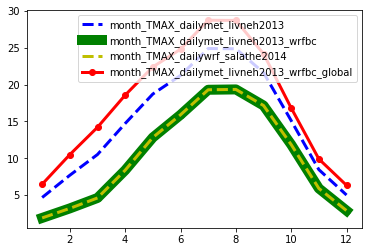

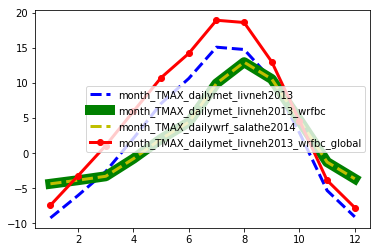

In [73]:
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    

fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    
    

### Plot and compare monthly precipitation

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 12 (major_axis) x 57 (minor_axis)
Items axis: month_PRECIP_dailymet_livneh2013 to month_PRECIP_dailywrf_salathe2014
Major_axis axis: 1 to 12
Minor_axis axis: (0, 48.40625, -121.46875) to (56, 48.03125, -121.40625)


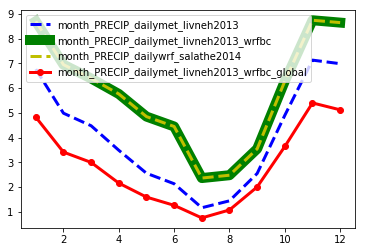

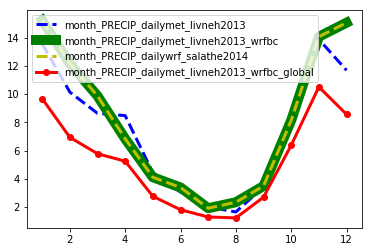

In [74]:
# let's compare monthly averages for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['month_PRECIP_dailymet_livneh2013','month_PRECIP_dailymet_livneh2013_wrfbc','month_PRECIP_dailywrf_salathe2014','month_PRECIP_dailymet_livneh2013_wrfbc_global']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey] 
panel_obj = pd.Panel.from_dict(obj)
print(panel_obj)

fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    #panel_obj.xs(key=(0.0, 48.53125, -121.59375), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
    
    #0.0, 48.84375, -121.15625
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    
    
    
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    
    #74.0, 48.59375, -121.71875
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    
  

### Plot and compare annual precipitation

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 61 (major_axis) x 57 (minor_axis)
Items axis: year_PRECIP_dailymet_livneh2013 to year_PRECIP_dailywrf_salathe2014
Major_axis axis: 1950 to 2010
Minor_axis axis: (0, 48.40625, -121.46875) to (56, 48.03125, -121.40625)


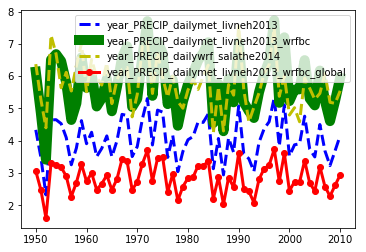

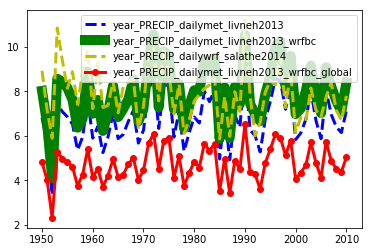

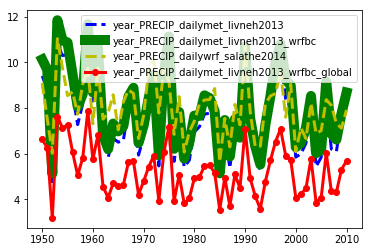

In [80]:
# let's compare monthly averages for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['year_PRECIP_dailymet_livneh2013','year_PRECIP_dailymet_livneh2013_wrfbc','year_PRECIP_dailywrf_salathe2014','year_PRECIP_dailymet_livneh2013_wrfbc_global']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey] 
panel_obj = pd.Panel.from_dict(obj)
print(panel_obj)

fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    #panel_obj.xs(key=(0.0, 48.53125, -121.59375), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
    
    #0.0, 48.84375, -121.15625
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    

fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    #panel_obj.xs(key=(0.0, 48.53125, -121.59375), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
    
    #0.0, 48.84375, -121.15625
    panel_obj.xs(key=(medElevStation[0][0], medElevStation[0][1], medElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    
        
    
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    
    #74.0, 48.59375, -121.71875
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    
  

### Plot and compare storm precipitation

In [106]:
print(panel_obj.iloc[:,21810:21860,:])

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 0 (major_axis) x 57 (minor_axis)
Items axis: PRECIP_dailymet_livneh2013 to PRECIP_dailywrf_salathe2014
Major_axis axis: None
Minor_axis axis: (0, 48.40625, -121.46875) to (56, 48.03125, -121.40625)


In [118]:
#panel_obj.xs(key=('1950-01-01 00:00:00','1952-01-01 00:00:00'), axis=1)
dr = pd.date_range('1950-01-01', '2010-12-31')
target = pd.Series(pd.date_range('2006-10-18', '2006-11-18'))

date_key = pd.Series(dr)[pd.Series(dr).apply(lambda x: x in set(target))].index
print(date_key.min(), date_key.max())

dr[date_key]


20744 20775


DatetimeIndex(['2006-10-18', '2006-10-19', '2006-10-20', '2006-10-21',
               '2006-10-22', '2006-10-23', '2006-10-24', '2006-10-25',
               '2006-10-26', '2006-10-27', '2006-10-28', '2006-10-29',
               '2006-10-30', '2006-10-31', '2006-11-01', '2006-11-02',
               '2006-11-03', '2006-11-04', '2006-11-05', '2006-11-06',
               '2006-11-07', '2006-11-08', '2006-11-09', '2006-11-10',
               '2006-11-11', '2006-11-12', '2006-11-13', '2006-11-14',
               '2006-11-15', '2006-11-16', '2006-11-17', '2006-11-18'],
              dtype='datetime64[ns]', freq=None)

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 31 (major_axis) x 57 (minor_axis)
Items axis: PRECIP_dailymet_livneh2013 to PRECIP_dailywrf_salathe2014
Major_axis axis: 2006-10-18 00:00:00 to 2006-11-17 00:00:00
Minor_axis axis: (0, 48.40625, -121.46875) to (56, 48.03125, -121.40625)


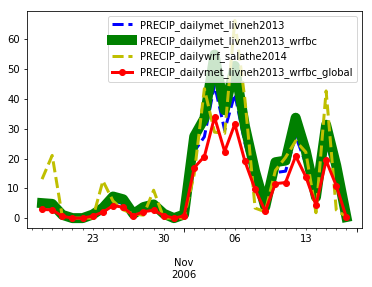

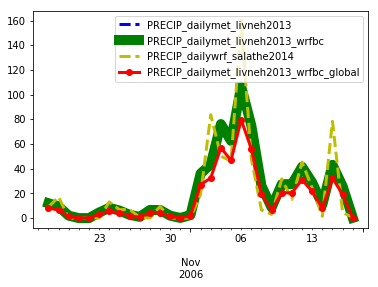

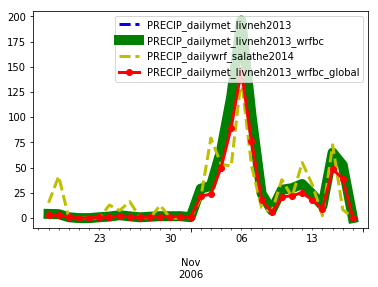

In [119]:
# let's compare monthly averages for TMAX using livneh, salathe, and the salathe-corrected livneh
comp = ['PRECIP_dailymet_livneh2013','PRECIP_dailymet_livneh2013_wrfbc','PRECIP_dailywrf_salathe2014','PRECIP_dailymet_livneh2013_wrfbc_global']

obj = dict()
for eachkey in ltm_0to3000.keys():
    if eachkey in comp:
        obj[eachkey] = ltm_0to3000[eachkey] 
#panel_obj = pd.Panel.from_dict(obj).iloc[:,21810:21860,:]
panel_obj = pd.Panel.from_dict(obj).iloc[:,date_key.min():date_key.max(),:]

print(panel_obj)

fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    #panel_obj.xs(key=(0.0, 48.53125, -121.59375), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
    
    #0.0, 48.84375, -121.15625
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    

fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    #panel_obj.xs(key=(0.0, 48.53125, -121.59375), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
    
    #0.0, 48.84375, -121.15625
    panel_obj.xs(key=(medElevStation[0][0], medElevStation[0][1], medElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    
        
    
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    
    #74.0, 48.59375, -121.71875
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)    
  

In [ ]:
#See Render points in Shape in OGH

## 6. (optional) - Run MetSim to dissagregate daily data to 3-hrly DHSVM inputs

See [Observatory_Sauk_MetSim_Python3.ipynb](https://jupyter.cuahsi.org/user/christinabandaragoda/notebooks/notebooks/data/f0f90f5645864e0d9c0e0209d0095d74/f0f90f5645864e0d9c0e0209d0095d74/data/contents/Observatory_Sauk_MetSim_Python3.ipynb) 
Edit this Markdown code hyperlink to your User Name if the Sauk Observatory HydroShare resource has been downloaded to your CUAHSI JupyterHub server personal user space.



## 7. (optional) - Update VIC model input file: soil

In [32]:
!wget https://www.hydroshare.org/django_irods/download/2474e3c1f33b4dc58e0dfc0824c72a84/data/contents/soil_base
ogh.switchUpVICSoil(input_file=os.path.join(homedir,'soil_base'),
                    output_file='soil',
                    mappingfile=mappingfile,
                    homedir=homedir)

--2018-01-23 22:26:25--  https://www.hydroshare.org/django_irods/download/2474e3c1f33b4dc58e0dfc0824c72a84/data/contents/soil_base
Resolving www.hydroshare.org (www.hydroshare.org)... 152.54.2.75
Connecting to www.hydroshare.org (www.hydroshare.org)|152.54.2.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7680162 (7.3M) [application-x/octet-stream]
Saving to: ‘soil_base’

soil_base           100%[===================>]   7.32M  --.-KB/s    in 0.1s    

2018-01-23 22:26:26 (72.0 MB/s) - ‘soil_base’ saved [7680162/7680162]

57 VIC grid cells have successfully been switched up.
Check your home directory for your new VIC soil model input set to your list of Lat/Long grid centroids.


## 8. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [33]:
print('This is the list of folders in your directory for this HydroShare resource.')
test = [each for each in os.listdir(homedir) if os.path.isdir(each)]
print(test)

This is the list of folders in your directory for this HydroShare resource.
['.ipynb_checkpoints', '__pycache__', 'livneh2013', 'salathe2014', 'biascorrWRF_liv', 'biascorrWRF_global']


Move each file on the server within the 'files' list to an :EXISTING" HydroShare Generic Resource content folder.  Parent_resource is the destination resource ID for an existing Generic Resource. Files is a list of filepaths.

In [ ]:
liv2013_tar = 'livneh2013.tar.gz'
wrf_tar = 'salathe2014.tar.gz'
biascorrWRF_liv_tar = 'biascorrWRF_liv.tar.gz'
biascorrWRF_global_tar = 'biascorrWRF_global.tar.gz'

!tar -zcf {liv2013_tar} livneh2013
!tar -zcf {wrf_tar} salathe2014
!tar -zcf {biascorrWRF_liv_tar} biascorrWRF_liv
!tar -zcf {biascorrWRF_global_tar} biascorrWRF_global


In [36]:
ThisNotebook='Observatory_Sauk_Climate_012318.ipynb' #check name for consistency
observatory_gridded_hydromet='ogh.py'
ogh_meta='ogh_meta.json'
soil = 'soil'
CorrectionFactors_wrfliv='BiasCorr_wrfbc.json'
CorrectionFactors_lowliv='BiasCorr_wrfbc_lowLiv.json'
listofgridpoints ='monkeysonatree.csv'

files=[ThisNotebook,
       liv2013_tar,
       observatory_gridded_hydromet,ogh_meta,
       wrf_tar,
       biascorrWRF_liv_tar,biascorrWRF_global_tar,
       soil,listofgridpoints,
       CorrectionFactors_wrfliv,CorrectionFactors_lowliv]

In [37]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Sauk Observatory Bias Correction Results - Livneh et al., 2013 to WRF (Salathe et al., 2014) and low elevation spatial average correction.'
abstract = 'This output is a bias correction to generate raw and hybrid gridded meteorology products.  This dataset was generated January 23, 20187'
keywords = ['Sauk', 'climate', 'WRF','hydrometeorology'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

Resource Created Successfully                           
Successfully Added Content Files                      


In [38]:
#check name for consistency
! cp Observatory_Sauk_Climate_012318.ipynb /home/jovyan/work/notebooks/data/Incubating-a-DREAM/Sauk_JupyterNotebooks

Go to the Github cloned repository using the terminal.


In [39]:
!ls

BiasCorr_wrfbc.json
BiasCorr_wrfbc_lowLiv.json
biascorrWRF_global
biascorrWRF_global.tar.gz
biascorrWRF_liv
biascorrWRF_liv.tar.gz
livneh2013
livneh2013.tar.gz
monkeysonatree.csv
Observatory_Sauk_Climate_012318.ipynb
Observatory_Sauk_Climate.ipynb
Observatory_Sauk_Incubator.ipynb
Observatory_Skagit_Observed_Streamflow.ipynb
ogh_meta.json
ogh.py
__pycache__
salathe2014
salathe2014.tar.gz
soil
soil_base


In [ ]:
#from  /home/jovyan/work/notebooks/data/Incubating-a-DREAM/Sauk_JupyterNotebooks
!git add .
!git commit -m "Updating Observatory Climate Download"
!git push origin master
